# Assignment 2 - Deep learning

### MECE

| Student Name | Contribution |
| -- | -- |
| Syed Muhammad Hassaan Chishti | Data preprocessing | 
| Rithwik Prem | DNN Model Building | 
| Arshia Pelathur Gururaj | DNN Model Tuning |
| Bibek Khadka | DNN Model Evaluation  |
| Joel Raju Padath | CNN Model Building  |
| Yash Mahendra | CNN Model Tuning  |
| Mathew Manoj Velookizhakethil | CNN Model Tuning  |
| Sameer Sharma | Interpretability of CNN | 
| Sweatha Palani | CNN Model Evaluation  |
| Yohankhan Habibkhan Pathan | Interpretability of DNN  | 


In [1]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm_notebook
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing import image
from lime import lime_image
from sklearn.preprocessing import label_binarize
from skimage.segmentation import mark_boundaries
from skimage.segmentation import slic

import warnings
warnings.filterwarnings('ignore')

In [141]:
# !pip install imblearn

# Load labels and EDA?

In [2]:
data_path = "./"
with open(os.path.join(data_path, "photos.json")) as file:
    labels_dict = {}
    for line in file:
        json_data = json.loads(line)
        labels_dict[json_data['photo_id']] = json_data['label']

In [3]:
label_df = pd.DataFrame(list(labels_dict.items()), columns=['Photo_ID', 'Label'])
label_df

,Photo_ID,Label
0,zsvj7vloL4L5jhYyPIuVwg,inside
1,HCUdRJHHm_e0OCTlZetGLg,outside
2,vkr8T0scuJmGVvN2HJelEA,drink
3,pve7D6NUrafHW3EAORubyw,food
4,H52Er-uBg6rNrHcReWTD2w,food
...,...,...
200093,4Zia9NkAfQNjMfcIDhwJ-g,food
200094,KB96KRZRhRm8hUkI-OpGEA,inside
200095,Klmojvaf2_2dP1XKzTsFmQ,food
200096,FNEiq7Mogec7t31OaU5juw,drink


Label
food       108152
inside      56029
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64


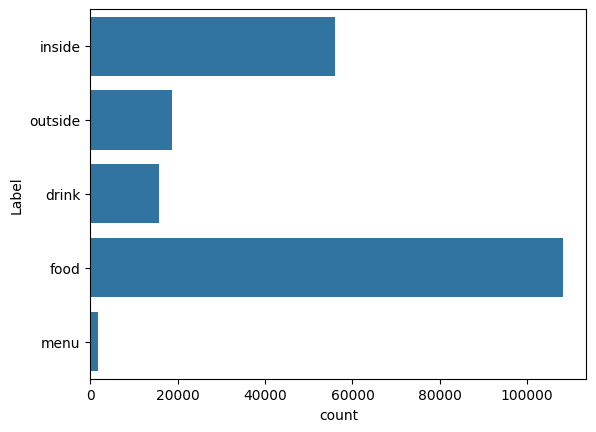

In [4]:
counts = label_df['Label'].value_counts()
print(counts)
sns.countplot(label_df['Label']);

We will be balancing all the target classes to handle class imbalance

In [5]:
min_samples = counts.min()
label_df_smaller = label_df.groupby('Label').apply(lambda x: x.sample(min_samples)).reset_index(drop=True)

In [6]:
label_df_smaller

,Photo_ID,Label
0,S8hhvpoZ2h1AAzdxHLCCfA,drink
1,DTELkgjfDnwyL_roFamQ3A,drink
2,svyrNRQPx2PWA1FeO3RL-w,drink
3,B_sfHCNzxK1i-qxDr4L9kQ,drink
4,Z07mjjDOIpW5dwWdQwCOSg,drink
...,...,...
8385,4r6UQdN27jVU7iWdMPiYpg,outside
8386,mZt6tnkr06SlwXItsHShmw,outside
8387,_thn82-SgHLBYsYLvulDBQ,outside
8388,KrBZ1W5hYDTb02OrbJQuGQ,outside


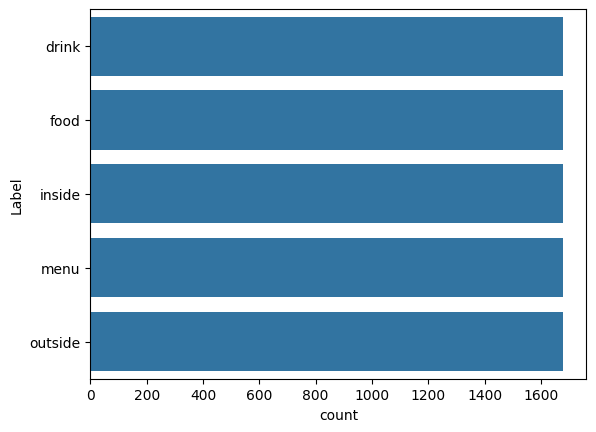

In [7]:
sns.countplot(label_df_smaller['Label']);

# Load Image Data
#### Ok we can just load these 8390 images no need for the entire dataset. Later with data augmentation we can increase the size of the dataset

## Load, resize and convert to arrays 

In [8]:
# let's go with the most popular target size
target_size = (224, 224)
images = []
labels = []

# skip if file has a problem, some files are throwing an error
skipped = []

# yeayyy tqdm
for index, row in tqdm_notebook(label_df_smaller.iterrows(), total=len(label_df_smaller)):    
    img_path = os.path.join(data_path, 'photos', f"{row['Photo_ID']}.jpg")
    try:
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(row['Label'])
    except:
        skipped.append(img_path)
        
images = np.array(images) 
labels = np.array(labels)

print(f"Total images processed: {images.shape}")
print(f"Total images skipped: {len(skipped)}")

  0%|          | 0/8390 [00:00<?, ?it/s]

Total images processed: (8387, 224, 224, 3)
Total images skipped: 3


In [9]:
skipped

['./photos\\5q-sAvIPl0yNeuAbNBPM1g.jpg',
 './photos\\ytJ4lihJrvyzMMRG-WwDNw.jpg',
 './photos\\-ZkmgGLJ7AJTjy96nocMNw.jpg']

## Train Test Split

In [10]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.3, random_state=100)

In [11]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((5870, 224, 224, 3), (5870,), (2517, 224, 224, 3), (2517,))

## One-hot Encoding of labels

In [12]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

train_labels_onehot = onehot_encoder.fit_transform(train_labels.reshape(len(train_labels), 1))
test_labels_onehot = onehot_encoder.transform(test_labels.reshape(len(test_labels), 1))

In [13]:
train_images.shape, train_labels_onehot.shape, test_images.shape, test_labels_onehot.shape

((5870, 224, 224, 3), (5870, 5), (2517, 224, 224, 3), (2517, 5))

In [14]:
train_labels[0], train_labels_onehot[0]

('drink', array([1., 0., 0., 0., 0.]))

In [15]:
pd.Series(train_labels).value_counts()

food       1196
menu       1186
inside     1184
drink      1162
outside    1142
Name: count, dtype: int64

## Image Preprocessing

In [16]:
# Normalize train data for DNNs
# DNN don't like rotation and other augumentations 
# since they rely on 1D pixel sequences instead of 2D spacial relationship of pixels
datagen_DNNs = ImageDataGenerator(
    rescale=1.0/255.0
)

# Normalize and augment train images
datagen_CNNs = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Normalize test images. We are not supposed to agument test data but we do need to normalize them.
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create data generators DNNs
train_generator_DNNs = datagen_DNNs.flow(
    train_images, train_labels_onehot, batch_size=32
)

# Create data generators CNNs
train_generator_CNNs = datagen_CNNs.flow(
    train_images, train_labels_onehot, batch_size=32
)

val_generator = val_datagen.flow(
    test_images, test_labels_onehot, batch_size=32
)

In [17]:
# We need to figure out the number of classes for the output layer
train_labels_onehot.shape[1], test_labels_onehot.shape[1]

(5, 5)

In [18]:
num_classes = train_labels_onehot.shape[1]

# Modeling 

## Baseline CNN model

In [20]:
# model = Sequential([
#     Conv2D(128, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
#     MaxPooling2D((2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(32, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dense(num_classes, activation='softmax')
# ])

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [21]:
# history = model.fit(train_generator_CNNs, epochs=5, validation_data=val_generator)

In [22]:
# # Plot training & validation accuracy values
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(['Train', 'Validation'], loc='upper left')

# # Plot training & validation loss values
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['Train', 'Validation'], loc='upper left')

# plt.show()

## Baseline DNN model

In [19]:
def plot_roc(y_true, y_prob):
    num_classes = test_labels_onehot.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calculate ROC curve and AUC for each class
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plotting the ROC curve for each class
    plt.figure(figsize=(10, 8))

    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} ROC curve (AUC = {roc_auc[i]:0.2f})')

    # Adding the diagonal reference line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Plot settings
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
    plt.legend(loc='lower right')
    plt.show()

In [24]:
dnn_model1 = Sequential([
    Flatten(input_shape=(target_size[0], target_size[1], 3)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

dnn_model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
dnn_model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,235,717 (294.63 MB)

 Trainable params: 77,235,717 (294.63 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history1 = dnn_model1.fit(train_generator_DNNs, epochs=10, validation_data=val_generator)

Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 48s 242ms/step - accuracy: 0.2589 - loss: 26.4169 - val_accuracy: 0.4100 - val_loss: 2.1198
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 38s 204ms/step - accuracy: 0.4027 - loss: 1.9648 - val_accuracy: 0.3878 - val_loss: 1.5956
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 37s 202ms/step - accuracy: 0.4781 - loss: 1.3334 - val_accuracy: 0.4760 - val_loss: 1.2768
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.4907 - loss: 1.3044 - val_accuracy: 0.4871 - val_loss: 1.2706
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 39s 214ms/step - accuracy: 0.4964 - loss: 1.2589 - val_accuracy: 0.4501 - val_loss: 1.3470
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 46s 249ms/step - accuracy: 0.5225 - loss: 1.2110 - val_accuracy: 0.4557 - val_loss: 1.3573
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 44s 240ms/step - accuracy: 0.5361 - loss: 1.1807 - val_accuracy: 0.4700 - val_loss: 1.3210
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 47s 254ms/step - accuracy: 0.4983 - loss: 

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step


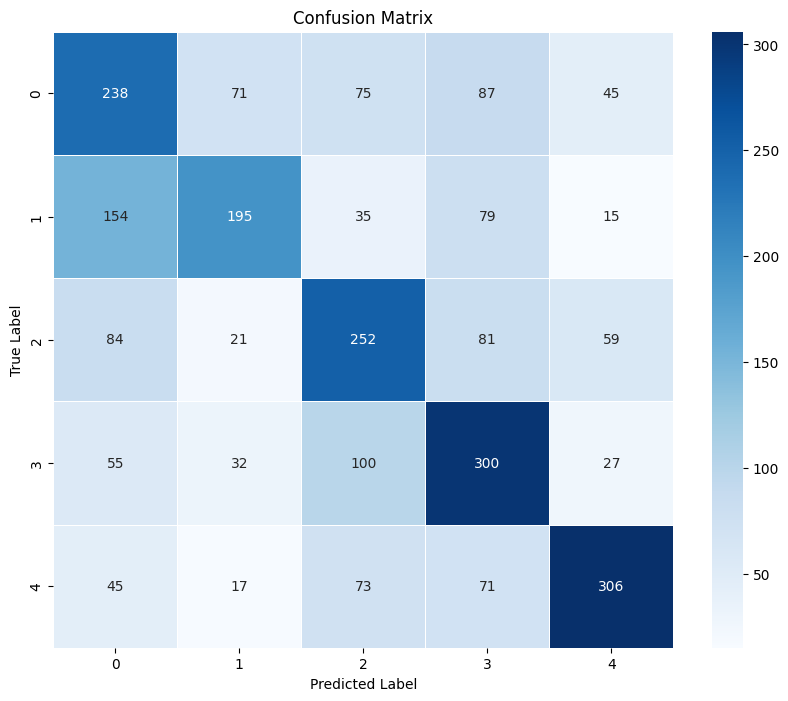

In [26]:
test_sample_scaled = test_images.astype('float32')/255.5
predictions = dnn_model1.predict(test_sample_scaled)
predicted_classes = np.argmax(predictions, axis=1)

# Convert true labels to class indices (if they are one-hot encoded)
true_classes = np.argmax(test_labels_onehot, axis=1)
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [27]:
report = classification_report(true_classes, predicted_classes)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.46      0.44       516
           1       0.58      0.41      0.48       478
           2       0.47      0.51      0.49       497
           3       0.49      0.58      0.53       514
           4       0.68      0.60      0.63       512

    accuracy                           0.51      2517
   macro avg       0.53      0.51      0.51      2517
weighted avg       0.52      0.51      0.51      2517



Performly really badly.

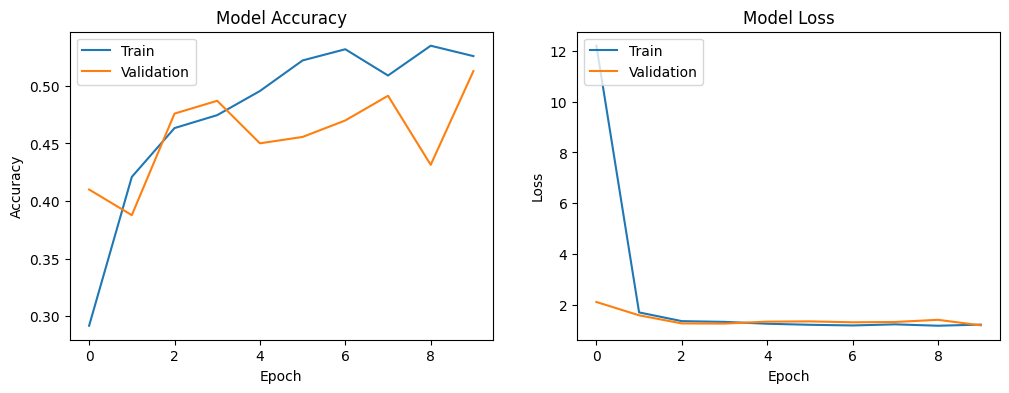

In [28]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

There is overfitting in the data as well as the model is not performing well. This could be because of low number of iterations or not using dropouts to handle overfitting. In model tuning we will be trying out difference approaches to improve this model performance.

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step


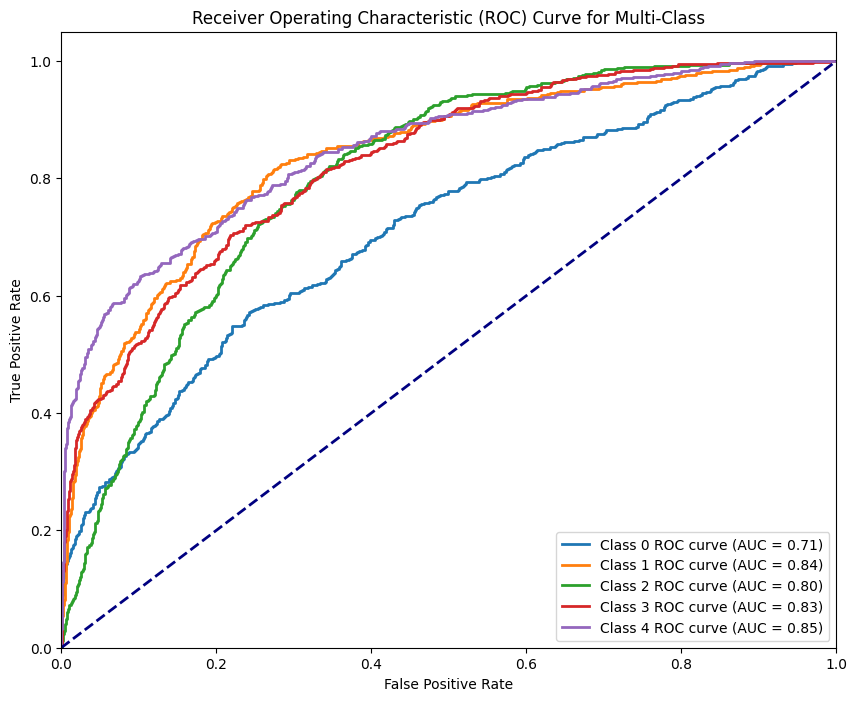

In [29]:
y_true = test_labels_onehot
y_prob = dnn_model1.predict(test_sample_scaled)

plot_roc(y_true, y_prob)

In [30]:
# dnn_model1.save('dnn_image_classification_base_model.h5')
dnn_model1.save('dnn_image_classification_base_model.keras')


## Model Tuning DNN

#### Tuning 1. Adding two layers of dropouts to handle the overfitting. And Batch Normalization for faster training.

In [31]:
dnn_model2 = Sequential([
    Flatten(input_shape=(target_size[0], target_size[1], 3)),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),  # Dropout to reduce overfitting

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),

    Dense(num_classes, activation='softmax')
])

dnn_model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
dnn_model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,239,301 (294.64 MB)

 Trainable params: 77,237,509 (294.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [32]:
history2 = dnn_model2.fit(train_generator_DNNs, epochs=10, validation_data=val_generator)

Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 66s 337ms/step - accuracy: 0.3717 - loss: 1.6467 - val_accuracy: 0.4883 - val_loss: 1.3084
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 49s 265ms/step - accuracy: 0.4860 - loss: 1.2720 - val_accuracy: 0.5034 - val_loss: 1.1932
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 45s 246ms/step - accuracy: 0.5061 - loss: 1.2116 - val_accuracy: 0.3703 - val_loss: 1.5351
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 38s 207ms/step - accuracy: 0.5353 - loss: 1.1779 - val_accuracy: 0.4934 - val_loss: 1.2780
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 37s 202ms/step - accuracy: 0.5428 - loss: 1.1383 - val_accuracy: 0.3679 - val_loss: 1.5011
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 37s 201ms/step - accuracy: 0.5568 - loss: 1.1224 - val_accuracy: 0.4779 - val_loss: 1.3389
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 37s 201ms/step - accuracy: 0.5801 - loss: 1.0827 - val_accuracy: 0.3170 - val_loss: 1.9543
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 37s 200ms/step - accuracy: 0.5646 - loss: 1

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


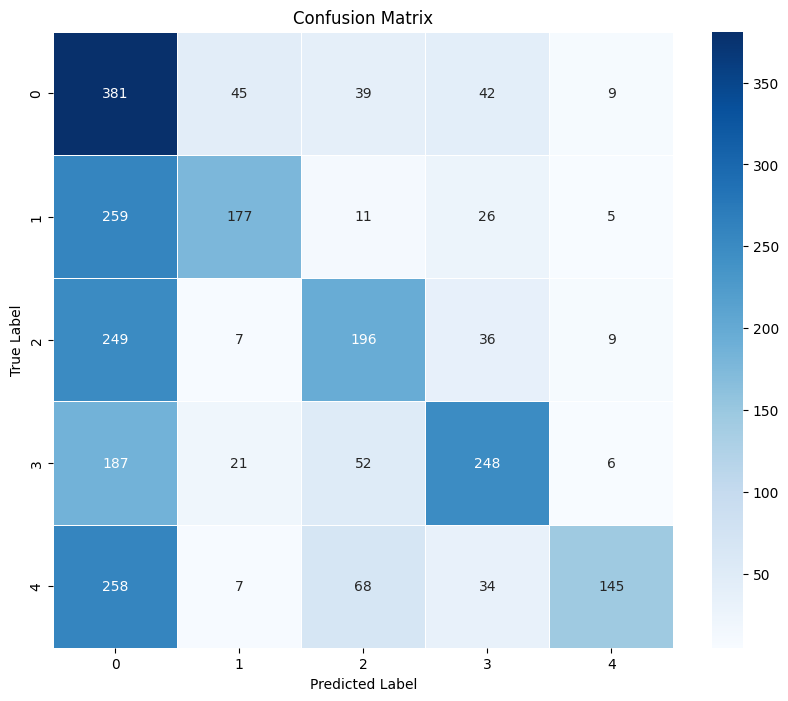

In [33]:
test_sample_scaled = test_images.astype('float32')/255.5
predictions = dnn_model2.predict(test_sample_scaled)
predicted_classes = np.argmax(predictions, axis=1)

# Convert true labels to class indices (if they are one-hot encoded)
true_classes = np.argmax(test_labels_onehot, axis=1)
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [34]:
report = classification_report(true_classes, predicted_classes)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.74      0.41       516
           1       0.69      0.37      0.48       478
           2       0.54      0.39      0.45       497
           3       0.64      0.48      0.55       514
           4       0.83      0.28      0.42       512

    accuracy                           0.46      2517
   macro avg       0.60      0.45      0.46      2517
weighted avg       0.60      0.46      0.46      2517



This is doing better than the Vanilla Model

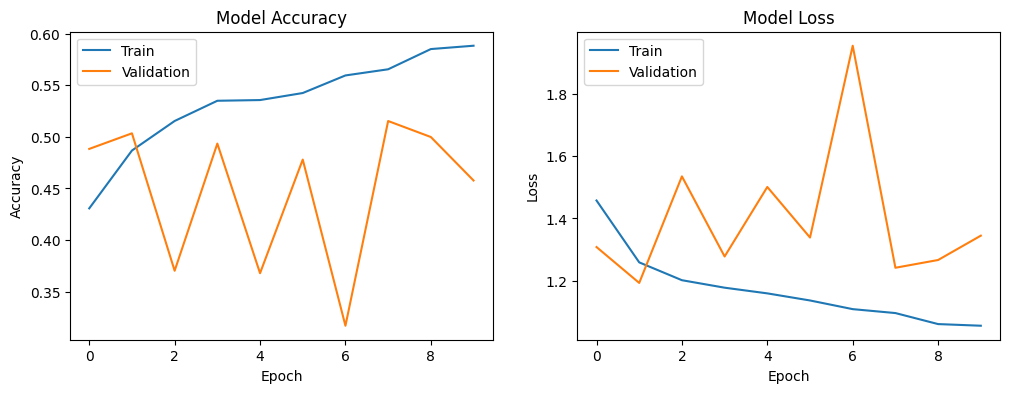

In [35]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Overfitting has reduced but is still present. Will try improving the performance of the model by adding another layer.

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


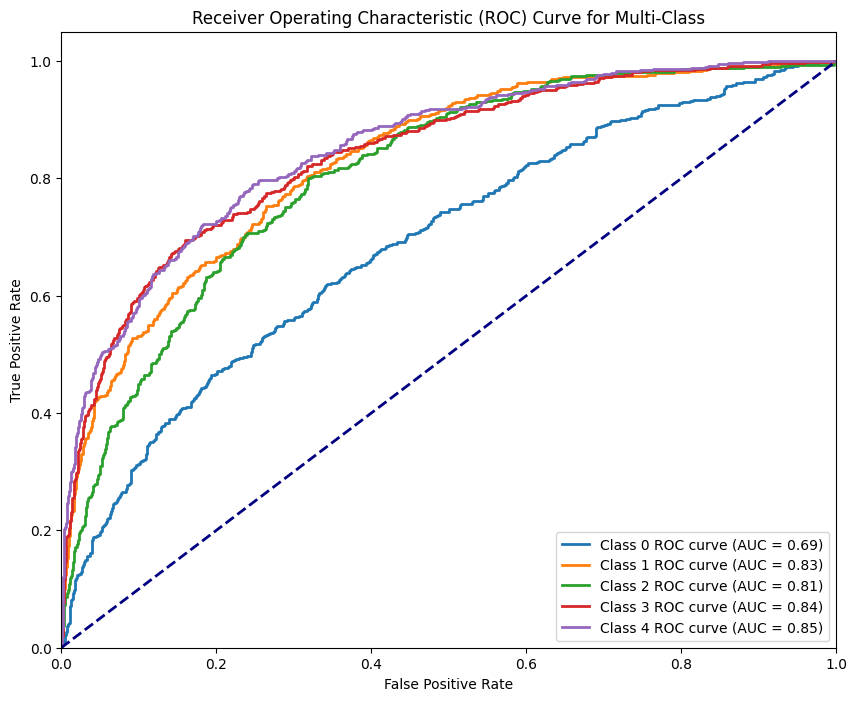

In [36]:
y_true = test_labels_onehot
y_prob = dnn_model2.predict(test_sample_scaled)

plot_roc(y_true, y_prob)

In [37]:
dnn_model2.save('dnn_image_classification_model2.keras')


#### Tuning 2. Added another layer for improving model performance. To handle underfitting

In [38]:
dnn_model3 = Sequential([
    Flatten(input_shape=(target_size[0], target_size[1], 3)),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),  # Dropout to reduce overfitting

    Dense(256, activation='relu'),
    BatchNormalization(),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu'),
    BatchNormalization(),

    Dense(num_classes, activation='softmax')
])

dnn_model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
dnn_model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,306,117 (294.90 MB)

 Trainable params: 77,303,813 (294.89 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [39]:
history3 = dnn_model3.fit(train_generator_DNNs, epochs=10, validation_data=val_generator)

Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 40s 206ms/step - accuracy: 0.3787 - loss: 1.6341 - val_accuracy: 0.4331 - val_loss: 1.4019
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 37s 202ms/step - accuracy: 0.4838 - loss: 1.2790 - val_accuracy: 0.4954 - val_loss: 1.2860
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 37s 203ms/step - accuracy: 0.5134 - loss: 1.2226 - val_accuracy: 0.5260 - val_loss: 1.1998
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 37s 203ms/step - accuracy: 0.5155 - loss: 1.1923 - val_accuracy: 0.4740 - val_loss: 1.3202
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 37s 201ms/step - accuracy: 0.5571 - loss: 1.1191 - val_accuracy: 0.5300 - val_loss: 1.1974
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 38s 205ms/step - accuracy: 0.5519 - loss: 1.1368 - val_accuracy: 0.4378 - val_loss: 1.4902
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 51s 279ms/step - accuracy: 0.5594 - loss: 1.1122 - val_accuracy: 0.4557 - val_loss: 1.4235
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 51s 279ms/step - accuracy: 0.5626 - loss: 1

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


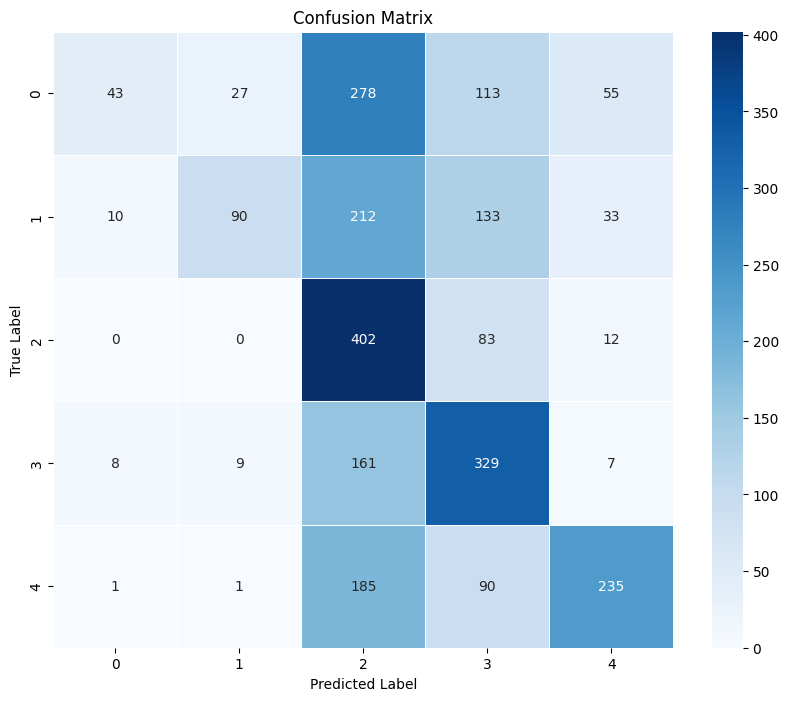

In [40]:
test_sample_scaled = test_images.astype('float32')/255.5
predictions = dnn_model3.predict(test_sample_scaled)
predicted_classes = np.argmax(predictions, axis=1)

# Convert true labels to class indices (if they are one-hot encoded)
true_classes = np.argmax(test_labels_onehot, axis=1)
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [41]:
report = classification_report(true_classes, predicted_classes)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.08      0.15       516
           1       0.71      0.19      0.30       478
           2       0.32      0.81      0.46       497
           3       0.44      0.64      0.52       514
           4       0.69      0.46      0.55       512

    accuracy                           0.44      2517
   macro avg       0.57      0.44      0.40      2517
weighted avg       0.57      0.44      0.40      2517



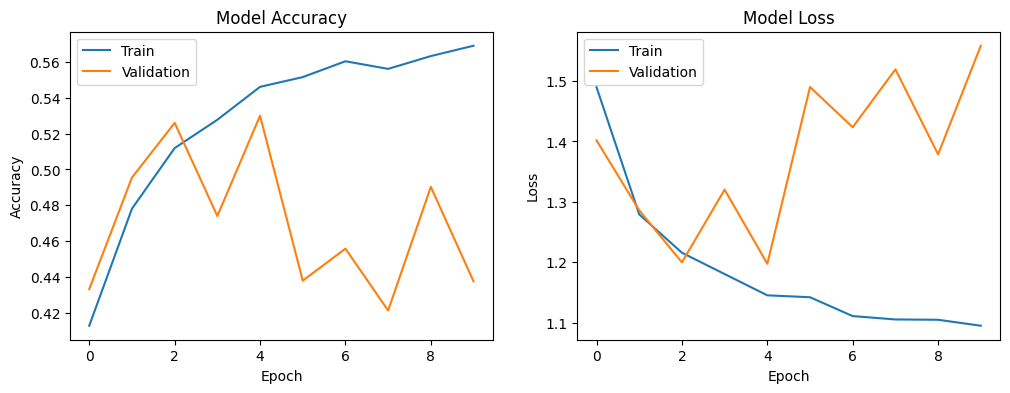

In [42]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

The model test performance has improved from 41% to 50% and the overfitting has reduced as well but it is still not performing well. 

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


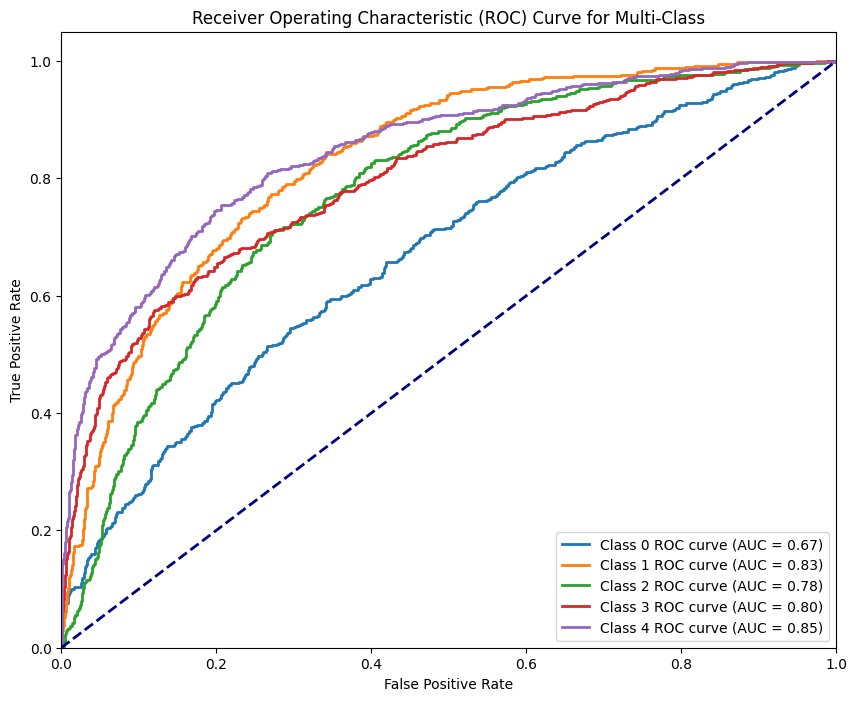

In [43]:
y_true = test_labels_onehot
y_prob = dnn_model3.predict(test_sample_scaled)

plot_roc(y_true, y_prob)

In [44]:
dnn_model3.save('dnn_image_classification_model3.keras')

#### Tuning 3. Changing the optimizer to see the performance and adding momentum to maintain consistent direction of parameter updates during saddle points and reducing complexity to handle overfitting

In [20]:
dnn_model4 = Sequential([
    Flatten(input_shape=(target_size[0], target_size[1], 3)),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(256, activation='relu'),
    BatchNormalization(),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu'),
    BatchNormalization(),


    Dense(num_classes, activation='softmax')
])

learning_rate = 0.01
momentum = 0.9
optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

dnn_model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
dnn_model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,256,325 (294.71 MB)

 Trainable params: 77,254,277 (294.70 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [21]:
history4 = dnn_model4.fit(train_generator_DNNs, epochs=10, validation_data=val_generator)

Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 173ms/step - accuracy: 0.3766 - loss: 1.6029 - val_accuracy: 0.3870 - val_loss: 1.6244
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.4646 - loss: 1.3214 - val_accuracy: 0.5089 - val_loss: 1.2296
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.4967 - loss: 1.2501 - val_accuracy: 0.5292 - val_loss: 1.1960
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 29s 156ms/step - accuracy: 0.5168 - loss: 1.2228 - val_accuracy: 0.4569 - val_loss: 1.3064
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 27s 145ms/step - accuracy: 0.5335 - loss: 1.1745 - val_accuracy: 0.5129 - val_loss: 1.2221
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 24s 130ms/step - accuracy: 0.5435 - loss: 1.1542 - val_accuracy: 0.5324 - val_loss: 1.2024
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.5544 - loss: 1.1219 - val_accuracy: 0.5324 - val_loss: 1.2005
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.5544 - loss: 1

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


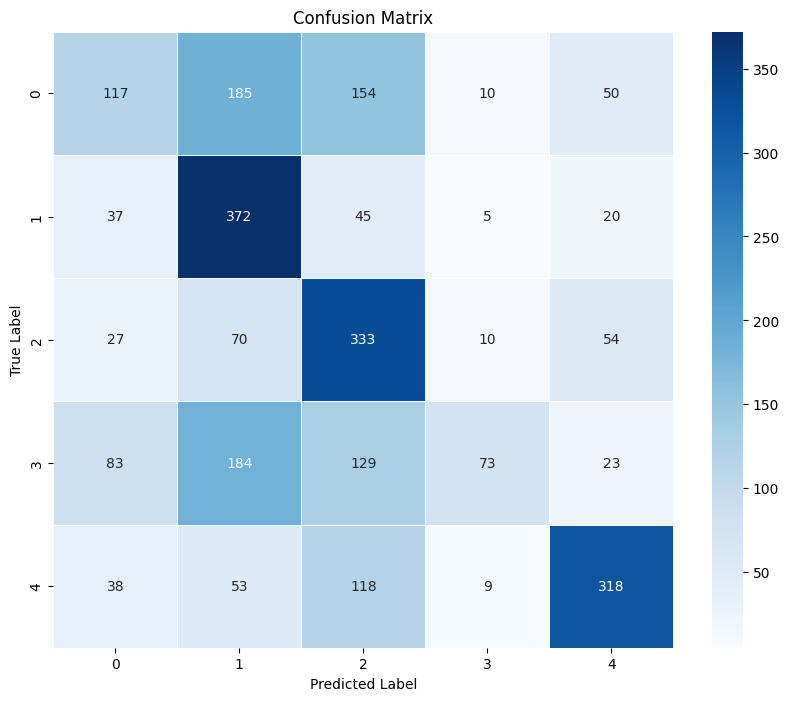

In [22]:
test_sample_scaled = test_images.astype('float32')/255.5
predictions = dnn_model4.predict(test_sample_scaled)
predicted_classes = np.argmax(predictions, axis=1)

# Convert true labels to class indices (if they are one-hot encoded)
true_classes = np.argmax(test_labels_onehot, axis=1)
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [23]:
report = classification_report(true_classes, predicted_classes)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.23      0.29       516
           1       0.43      0.78      0.55       479
           2       0.43      0.67      0.52       494
           3       0.68      0.15      0.24       492
           4       0.68      0.59      0.64       536

    accuracy                           0.48      2517
   macro avg       0.52      0.48      0.45      2517
weighted avg       0.52      0.48      0.45      2517



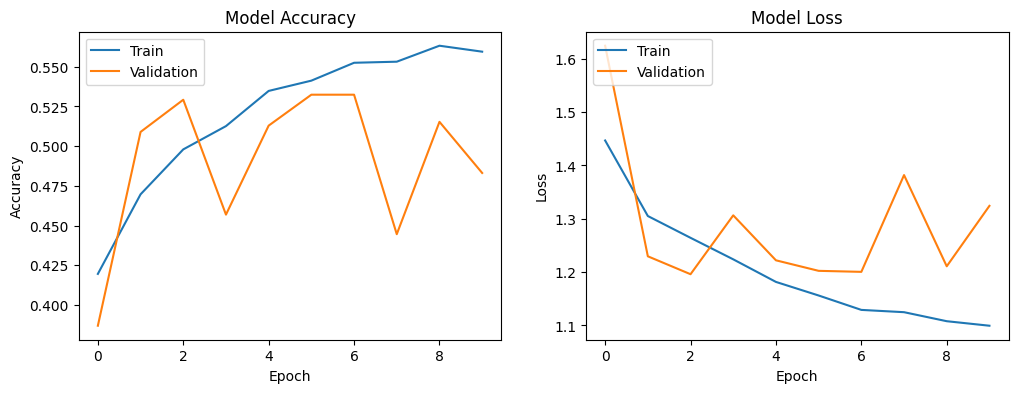

In [24]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Performed slightly better but not much difference. 

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


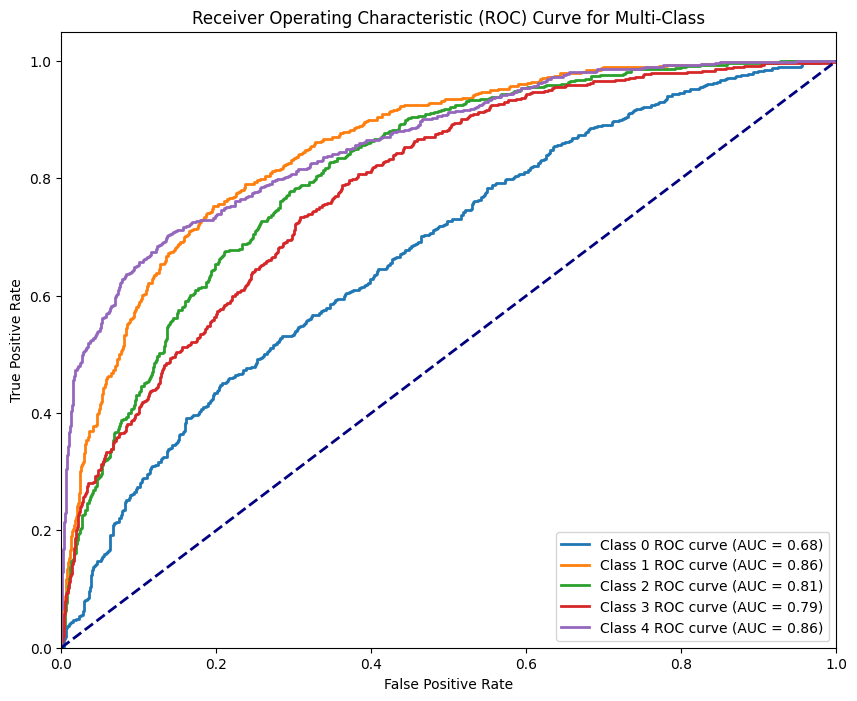

In [25]:
y_true = test_labels_onehot
y_prob = dnn_model4.predict(test_sample_scaled)

plot_roc(y_true, y_prob)

In [51]:
dnn_model4.save('dnn_image_classification_model4.keras')

#### Summary DNN:

From the base model we have seen an overall increase in the test accuracy but overfitting is present greatly. Adding dropouts, changing optimizer or changing layer structures has not had much difference to the model. To conclude, DNN is not a suitable choice for image related modelling.

Best Model: dnn_model4. It has better AUC score for the target classes

## Local Interpretability of DNN

In [58]:
# !pip install lime

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/5000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

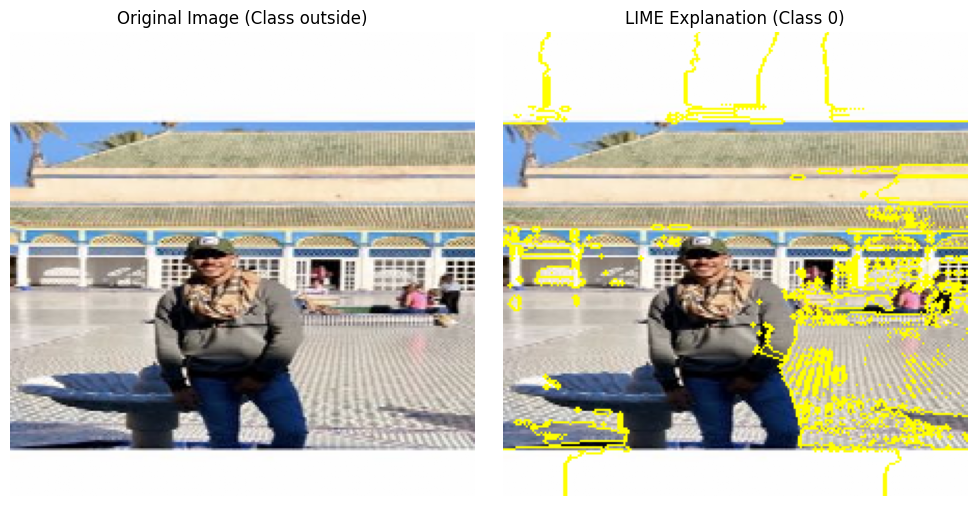

In [27]:
num_classes = train_labels_onehot.shape[1]
model = dnn_model4
img = test_images[0]  
img_label = test_labels[0] 

# Expand dimensions for batch size (from (height, width, channels) to (1, height, width, channels))
test_image_batch = np.expand_dims(img, axis=0)

# Normalize the test image (if required)
test_image_batch = test_image_batch / 255.0  # Adjust based on your model's input preprocessing

def predict_fn(images):
    images = np.array(images, dtype=np.float32)  # Ensure the correct data type
    return model.predict(images)

# Get the model's prediction for the test image
predicted_probs = model.predict(test_image_batch)
predicted_class_index = np.argmax(predicted_probs)

# LIME explainer instance
explainer = lime_image.LimeImageExplainer()

# Now use LIME to explain this test image
explanation = explainer.explain_instance(
    img, 
    predict_fn, 
    top_labels=5, 
    hide_color=0, 
    num_samples=5000
)

# Get the image and mask for visualization
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=20, 
    hide_rest=False
)

# Plotting the original and explained image side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Original image
axs[0].imshow(img/255.0)
axs[0].set_title(f'Original Image (Class {img_label})')
axs[0].axis('off')

# LIME explained image
axs[1].imshow(mark_boundaries(temp / 255.0, mask))  # Normalize for visualization purposes
axs[1].set_title(f'LIME Explanation (Class {explanation.top_labels[0]})')
axs[1].axis('off')

plt.tight_layout()
plt.show()


**LIME Explanation**:

- LIME (Local Interpretable Model-agnostic Explanations) helps in understanding which parts of the image contributed most to the model’s prediction. The LIME output highlights specific regions of the image that played the most importance in the model’s decision-making process

- The LIME output shows that certain areas of the image, such as parts of the food truck’s window, edges, and possibly text on the signs, were crucial for the model’s classification. These highlighted regions are marked in yellow on the grayscale version of the original image.

**Model Focus**:

- The model seems to focus on distinct features like edges, text, and specific patterns within the image. This indicates that the model is likely using these visual cues to differentiate between classes.

**Improvement Areas**:

- If the model is highlighting irrelevant areas or missing important features, it might indicate we need for further training or data augmentation. Understanding these insights can help in refining the model, such as by providing more diverse training data or adjusting preprocessing steps.

By leveraging LIME, we can gain valuable insights into a model’s behavior, which can guide further improvements and ensure the model is making informed and reliable predictions. 

## Global Interpretability of DNN

In [131]:
# !pip install shap

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


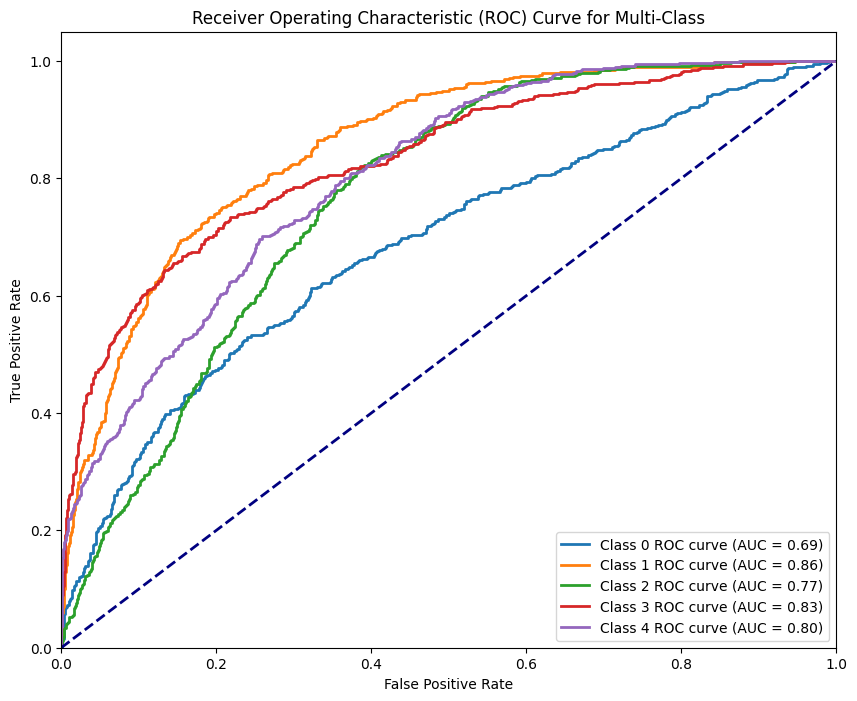

In [132]:
import shap
y_true = test_labels_onehot
y_prob = dnn_model4.predict(test_sample_scaled)

plot_roc(y_true, y_prob)


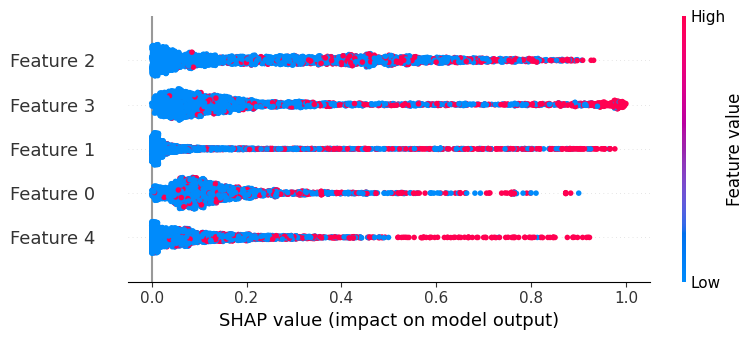

In [133]:
shap.summary_plot(y_prob, y_true)


#### Insights from the Shap Plot about the model:

- The horizontal axis represents the SHAP value, indicating the impact on the model’s output, ranging from 0.0 to 1.0. The vertical axis lists features from ‘Feature 0’ to ‘Feature 4’. Each dot represents a feature’s value for a particular instance, with colors transitioning from blue (low value) to red (high value), showing how different feature values affect the model’s predictions.


- Interpreting the SHAP plot, we see that ‘Feature 2’ and ‘Feature 4’ have a wide spread of SHAP values, suggesting they significantly influence the model’s output. The clustering of dots around certain SHAP values for ‘Feature 1’ indicates that high values of this feature consistently have a strong impact on the model’s predictions. This insight helps us understand which features are most critical in the model’s decision-making process.

- Feature 0: This feature shows a moderate spread of SHAP values, indicating it has a noticeable but not dominant impact on the model’s predictions.

- Feature 1: With a clustering of dots around certain SHAP values, this feature consistently influences the model’s output when it has high values.

- Feature 2: Exhibiting a wide spread of SHAP values, this feature significantly affects the model’s predictions, making it one of the most influential features.


- Feature 3: This feature has a more concentrated spread, suggesting it has a consistent but less impactful role in the model’s decision-making process.

- Feature 4: Similar to Feature 2, this feature shows a broad range of SHAP values, indicating a strong influence on the model’s output.


#### Further Improvements:

To further improve the model, we could investigate instances with extreme SHAP values to identify potential anomalies or data issues. Simplifying the model by removing or combining features with less impact could also enhance performance without sacrificing accuracy. Additionally, exploring feature interactions might reveal deeper insights into the model’s behavior.



#### Comculsion:

The SHAP plot analysis reveals that features like 'Feature 2' and 'Feature 4' have a significant influence on the model's predictions due to their wide spread of SHAP values, indicating high impact. 'Feature 1' consistently affects the model's output when its values are high. In contrast, 'Feature 0' and 'Feature 3' play a less dominant but still relevant role. These insights provide a clear understanding of the feature importance, guiding potential improvements such as addressing outliers, refining feature selection, and exploring feature interactions to optimize model performance.